# Tweet Scraping and NLP
- Author: Kimberly Yeo
- Module: Capstone
- Date: 2/11/2021

## Import packages

In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import snscrape.modules.twitter as sntwitter
import nltk
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Scrape training data tweets from a Bitcoin news account

In [2]:
%%time
# Creating list to append tweet data to
tweets_list1 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:BTCTN since:2018-09-29 until:2021-09-29').get_items()):
    tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# Creating a dataframe from the tweets list above 
raw_tweets = pd.DataFrame(tweets_list1, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

ScraperException: Unable to find guest token

In [3]:
raw_tweets.head()

NameError: name 'raw_tweets' is not defined

In [4]:
# Saving raw tweets
raw_tweets.to_csv("raw_tweets.csv", index=False)

## Clean and merge Tweets data by date

In [6]:
sub_tweets_df = raw_tweets[["Datetime", "Text"]]
sub_tweets_df.head()

,Datetime,Text
0,2021-09-28 23:32:20+00:00,"""This is not going to end well if it stays out..."
1,2021-09-28 22:39:58+00:00,Authorities in #Russia are trying to identify ...
2,2021-09-28 21:32:43+00:00,"Verifone, a global payment system provider wit..."
3,2021-09-28 19:32:25+00:00,"“We live in a technological age,” Paul Oakenfo..."
4,2021-09-28 19:01:27+00:00,"""The total number of mobile phone users in Afr..."


In [7]:
dates_list = []

for idx, row in sub_tweets_df.iterrows():
    date, time = str(row.Datetime).split(" ")
    dates_list.append(date)

sub_tweets_df["Date"] = dates_list        

<ipython-input-7-d201eefd5ab7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_tweets_df["Date"] = dates_list


In [8]:
sub_tweets_df = sub_tweets_df[["Date", "Text"]]
sub_tweets_df.head()

,Date,Text
0,2021-09-28,"""This is not going to end well if it stays out..."
1,2021-09-28,Authorities in #Russia are trying to identify ...
2,2021-09-28,"Verifone, a global payment system provider wit..."
3,2021-09-28,"“We live in a technological age,” Paul Oakenfo..."
4,2021-09-28,"""The total number of mobile phone users in Afr..."


In [9]:
# Save clean tweets data
sub_tweets_df.to_csv("clean_tweets.csv", index=False)

In [2]:
# Load clean tweets data
sub_tweets_df = pd.read_csv("clean_tweets.csv")

In [10]:
sub_tweets_df["Text"][2]

'Verifone, a global payment system provider with 35 million devices in 150 countries, is rolling out #crypto payment support in the U.S. #bitcoin #cryptocurrency https://t.co/al1JYkCyNo'

In [11]:
re.sub(r'http\S+', '', sub_tweets_df["Text"][2])

'Verifone, a global payment system provider with 35 million devices in 150 countries, is rolling out #crypto payment support in the U.S. #bitcoin #cryptocurrency '

In [12]:
# Clean sub_tweets_df (remove links)
for idx, row in sub_tweets_df.iterrows():
    sub_tweets_df["Text"].iloc[idx] = re.sub(r'http\S+', '', sub_tweets_df["Text"].iloc[idx])

In [13]:
sub_tweets_df["Text"][1]

'Authorities in #Russia are trying to identify investors defrauded by the notorious crypto pyramid scheme #Finiko. '

In [14]:
# Merging tweets by date
# Since each tweet has a space at the end (due to the removal of the links), we will simply append each tweet together
tweets_df = sub_tweets_df.groupby('Date')['Text'].apply(lambda x: ''.join(x)).reset_index()

In [15]:
tweets_df.head()

,Date,Text
0,2018-09-29,New POS Terminal by Pundix Allows Nigerians to...
1,2018-09-30,China’s Oldest Science and Tech Publication Ac...
2,2018-10-01,Northern Bitcoin Ag Lists on Munich Stock Exch...
3,2018-10-02,"BCH Roundup: Merchant Adoption, Wallet Service..."
4,2018-10-03,Increasing Number of Crypto ATMs in Europe Sup...


In [16]:
tweets_df["Text"][0]

'New POS Terminal by Pundix Allows Nigerians to Make Purchases in Bitcoin  SEC, CFTC, FBI Take Action Against Bitcoin-Funded Securities Dealer 1Broker  New Stablecoins: From Cryptopound and Metal-Backed Swiss Coin to Mongolian ‘Candy’  Markets Update: Digital Asset Consolidation and Accumulation Continues  Wendy McElroy: Crypto’s Means Are Its End – as Crypto-Statists Well Know  Braiins OS Publishes Open Source Firmware for Mining Rigs  The Daily: Fiat vs Crypto Laundering, Bitcoin Anniversary Cash-Ins  Debit Card Issuer Bitnovo Announces Bitcoin Cash Support \n #bch Exchanges Roundup: Ledgerx Readies ETH Futures, Coinbase Partners With Caspian  Popular Bitcoin Wallet Samourai Ditches All Government Currencies  Payments Platform Wirex Launches Iban for Spanish and French Users, Doubles Account Limits  European Regulator Renews Restrictions on Crypto-Based Derivatives  '

In [23]:
# Save merged tweets
tweets_df.to_csv("tweets_condensed.csv", index=False)

## Text cleaning for Tweets data

In [2]:
# Import text cleaning packages
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))
import nltk.stem  as stem
import string
snowball_stemmer = stem.snowball.SnowballStemmer("english")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kimberlyyeo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimberlyyeo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
tweets_df = pd.read_csv("tweets_condensed.csv")

In [57]:
for idx, row in tweets_df.iterrows():
    words = (nltk.word_tokenize(row["Text"]))
    filtered_words = [x for x in words if x not in stopWords]
    meaningful_words = [x for x in filtered_words if x not in string.punctuation]
    words = [snowball_stemmer.stem(w) for w in meaningful_words ]
    words = [x for x in words if not any(c.isdigit() for c in x)]
    sentence = ' '.join(str(x) for x in words)
    tweets_df["Text"].iloc[idx] = sentence

In [58]:
tweets_df.head()

,Date,Text
0,2018-09-29,new pos termin pundix allow nigerian make purc...
1,2018-09-30,china ’ oldest scienc tech public accept btc s...
2,2018-10-01,northern bitcoin ag list munich stock exchang ...
3,2018-10-02,bch roundup merchant adopt wallet servic hacka...
4,2018-10-03,increas number crypto atm europ support bch op...


In [59]:
# Save cleaned tweets
tweets_df.to_csv("cleaned_tweets.csv", index=False)

## Load Bitcoin price data

In [60]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-29,6643.100098,6643.100098,6511.649902,6601.959961,6601.959961,4.363690e+09
1,2018-09-30,6604.709961,6643.779785,6566.540039,6625.560059,6625.560059,4.002280e+09
2,2018-10-01,6619.850098,6653.299805,6549.080078,6589.620117,6589.620117,4.000970e+09
3,2018-10-02,6593.240234,6611.839844,6537.899902,6556.100098,6556.100098,3.979260e+09
4,2018-10-03,6553.859863,6571.459961,6454.029785,6502.589844,6502.589844,3.887310e+09


## Merge Tweets and Bitcoin data

In [61]:
# Load merged tweets data
tweets_df = pd.read_csv("cleaned_tweets.csv")

In [62]:
# Calculate daily returns as percentage price changes
df["Return"] = 100 * (df["Adj Close"].pct_change())
df["Log_Return"] = np.log(df["Adj Close"]).diff().mul(100) # rescale to faciliate optimization
df = df.dropna()

In [63]:
# Merging tweets and bitcoin data dataframes
merged_df = df.merge(tweets_df, how='inner', on='Date')

## Clean final dataframe

In [64]:
final_df = merged_df[["Date", "Text"]]
final_df.head()

,Date,Text
0,2018-09-30,china ’ oldest scienc tech public accept btc s...
1,2018-10-01,northern bitcoin ag list munich stock exchang ...
2,2018-10-02,bch roundup merchant adopt wallet servic hacka...
3,2018-10-03,increas number crypto atm europ support bch op...
4,2018-10-04,four court case confirm cryptocurr are commod ...


In [65]:
final_df["Obs_Vol"] = merged_df["Return"].sub(merged_df["Return"].mean()).pow(2)
final_df.head()

<ipython-input-65-8f8b7104c70e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Obs_Vol"] = merged_df["Return"].sub(merged_df["Return"].mean()).pow(2)


,Date,Text,Obs_Vol
0,2018-09-30,china ’ oldest scienc tech public accept btc s...,0.013610
1,2018-10-01,northern bitcoin ag list munich stock exchang ...,0.613488
2,2018-10-02,bch roundup merchant adopt wallet servic hacka...,0.561735
3,2018-10-03,increas number crypto atm europ support bch op...,1.117252
4,2018-10-04,four court case confirm cryptocurr are commod ...,0.807727


In [66]:
# Save final dataframe
final_df.to_csv("tweets_bitcoin.csv", index=False)

## TFIDF

In [3]:
final_df = pd.read_csv("tweets_bitcoin.csv")

In [4]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(final_df['Text'])

In [5]:
df1 = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
final_df.drop('Text', axis=1, inplace=True)
final_df = pd.concat([final_df, df1], axis=1)

In [6]:
train = final_df[:-29].dropna()
test = final_df[-29:].dropna()

In [11]:
train.head()

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,zuckbucks,zuckerberg,zug,zulutrade,zurich,zytara,álvarez,ángel,ștefan,аre
0,2018-09-30,0.013610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-10-01,0.613488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-10-02,0.561735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-10-03,1.117252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
test.head()

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,zuckbucks,zuckerberg,zug,zulutrade,zurich,zytara,álvarez,ángel,ștefan,аre
1058,2021-08-31,0.000012,0.0,0.040108,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1059,2021-09-01,11.033992,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1060,2021-09-02,0.552453,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1061,2021-09-03,1.377126,0.0,0.021308,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1062,2021-09-04,0.161788,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.076478,0.0,0.0,0.0,0.0


## XGBoost Trial

In [16]:
# Hyperparameter tuning
n_folds = 10

param_grid = {
            'objective': ["reg:squarederror"],
            'learning_rate': [0.01],
            'seed': [123],
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }

grid_searcher = GridSearchCV(estimator=xgb.XGBRegressor(),
                            param_grid=param_grid,
                            cv=KFold(n_splits=n_folds,
                                    shuffle=True),
                            scoring="neg_mean_squared_error")

In [11]:
# Hyperparameter tuning
n_folds = 5

param_grid = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }

grid_searcher = GridSearchCV(estimator=xgb.XGBRegressor(),
                            param_grid=param_grid,
                            cv=KFold(n_splits=n_folds,
                                    shuffle=True),
                             scoring="neg_mean_squared_error")

In [12]:
%%time
grid_searcher.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

CPU times: user 3min 56s, sys: 4.64 s, total: 4min 1s
Wall time: 1min 48s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mon...ints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                            

In [ ]:
# Rent a server on AWS to do hyperparameter tuning
# OR use Google cloud

In [ ]:
# Create a hyperparameter concerning lag and use GridSearchCV
# Write a function to make the hyperparameter (use elbow method)
# If GridSearchCV does not work, write your own helper function
# Also incorporate the traditional time series feature engineering on observed volatility itself

In [13]:
xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, learning_rate=0.01, seed = 123)
xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

[11:17:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
y_pred = xgb_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 14.105
MSE: 970.762


## Create a 1-day lag for TFIDF

In [15]:
lag1_df = final_df.copy()

In [16]:
lag1_df = pd.concat([final_df["Date"], lag1_df.iloc[:,1:].shift(1)], axis=1)

In [17]:
lag1_df

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,zuckbucks,zuckerberg,zug,zulutrade,zurich,zytara,álvarez,ángel,ștefan,аre
0,2018-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-10-01,0.013610,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-10-02,0.613488,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-10-03,0.561735,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,1.117252,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,7.783189,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,2021-09-25,23.222015,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1084,2021-09-26,0.279093,0.000000,0.027265,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,2021-09-27,0.829626,0.075012,0.030023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create n-day lags for TFIDF

In [ ]:
# Changed the function such that observed volatility is not shifted

In [57]:
def get_lag_df(n_lag, final_df):
    lag_df = final_df.copy()
    lag_df = pd.concat([final_df[["Date", "Obs_Vol"]], lag_df.iloc[:,2:].shift(n_lag)], axis=1)
    return lag_df

In [58]:
lag_dict = {}
for i in range(1, 10):
    lag_dict["lag{}_df".format(i)] = get_lag_df(i, final_df).dropna()

In [59]:
lag_dict["lag2_df"]

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,zuckbucks,zuckerberg,zug,zulutrade,zurich,zytara,álvarez,ángel,ștefan,аre
2,2018-10-02,0.561735,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-10-03,1.117252,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,0.807727,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2018-10-05,0.207422,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2018-10-06,0.572715,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,2021-09-25,0.279093,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1084,2021-09-26,0.829626,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,2021-09-27,6.211249,0.000000,0.027265,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
lag_dict["lag3_df"]

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,zuckbucks,zuckerberg,zug,zulutrade,zurich,zytara,álvarez,ángel,ștefan,аre
3,2018-10-03,1.117252,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,0.807727,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2018-10-05,0.207422,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2018-10-06,0.572715,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2018-10-07,0.000346,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,2021-09-25,0.279093,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1084,2021-09-26,0.829626,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,2021-09-27,6.211249,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Create function to produce graph
# Make sure to explain the elbow method in the notebook/capstone (where I have to manually eyeball it, think about automation)
min_mae = 0
count = 1
for k in lag_dict.keys():
    df = lag_dict[k]
    train = df[:-count].dropna()
    test = df[-count:].dropna()
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, learning_rate=0.01, seed = 123)
    xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
    y_pred = xgb_model.predict(test[df1.columns])
    mae = mean_absolute_error(test["Obs_Vol"], y_pred)
    print(mae)
    if count == 1:
        min_mae = mae
        best_lag = k
    else:
        if min_mae > mae:
            min_mae = mae
            best_lag = k
    count += 1
print(best_lag)

7.8836581364463
6.255430081211741
4.43708228044915
3.6546594267712473
7.250789098111873
7.061903208213366
12.500322348837232
14.210938627753606
22.655570114050548
lag4_df


In [62]:
# Lag tuning function which produces elbow plot
def lag_tuning(lag_dict, accur_metric):
    min_mae = 0
    min_mse = 0
    count = 1
    lag_score_df = pd.DataFrame(columns = ["lag", accur_metric])
    for k in lag_dict.keys():
        df = lag_dict[k]
        train = df[:-count].dropna()
        test = df[-count:].dropna()
        xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                      n_estimators = 10, learning_rate=0.01, seed = 123)
        xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
        y_pred = xgb_model.predict(test[df1.columns])
        if accur_metric == "mae":
            mae = mean_absolute_error(test["Obs_Vol"], y_pred)
            if count == 0:
                min_mae = mae
                best_lag = k
            else:
                if min_mae > mae:
                    min_mae = mae
            lag_score_df = lag_score_df.append({"lag": count, accur_metric: mae}, ignore_index=True)
        elif accur_metric == "mse":
            mse = mean_squared_error(test["Obs_Vol"], y_pred)
            if count == 1:
                min_mse = mse
                best_lag = k
            else:
                if min_mse > mse:
                    min_mse = mse
            lag_score_df = lag_score_df.append({"lag": count+1, accur_metric: mse}, ignore_index=True)
        count += 1
    plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
    plt.show()
    return lag_score_df

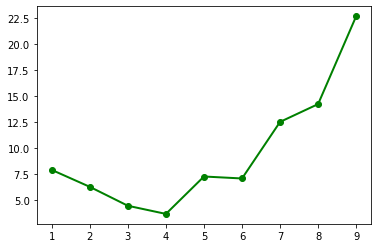

CPU times: user 1min 51s, sys: 2.99 s, total: 1min 54s
Wall time: 47.7 s


,lag,mae
0,1.0,7.883658
1,2.0,6.255430
2,3.0,4.437082
3,4.0,3.654659
4,5.0,7.250789
5,6.0,7.061903
6,7.0,12.500322
7,8.0,14.210939
8,9.0,22.655570


In [63]:
%%time
lag_tuning(lag_dict, "mae")

In [82]:
# Choosing lag_4 as the best dataframe with 4-day lagged tfidf features
xgb_df = lag_dict["lag4_df"]

## Date specific feature engineering

In [ ]:
# Do some cleaning of tfidf (removing stopwords, stemming, lemmatization)
# Look up sparse dataframe algorithms
# Find feature importance

In [ ]:
# Can consider adding international holidays (simple one hot encoding)
# Consider adding federal reserve announcements

In [83]:
xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])

In [87]:
xgb_df['Year'] = xgb_df['Date'].dt.year 
xgb_df['Month'] = xgb_df['Date'].dt.month 
xgb_df['Day'] = xgb_df['Date'].dt.day

xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek  
# xgb_df['dayofweek_name']= xgb_df['Date'].dt.weekday_name

In [88]:
xgb_df

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,zurich,zytara,álvarez,ángel,ștefan,аre,Year,Month,Day,dayofweek_num
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,4,3
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,5,4
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,6,5
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,7,6
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,24,4
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,25,5
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,26,6
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,27,0


## Lags for observed volatility

In [94]:
def get_lags(lag_start, lag_end, df):
    for i in range(lag_start, lag_end):
        df['lag_'+str(i)] = df.Obs_Vol.shift(i)
    return df

In [95]:
xgb_df = get_lags(1, 8, xgb_df)

In [96]:
xgb_df

,Date,Obs_Vol,00,000,00000001,00005,0001,00042069,0008,001,...,Month,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,5,4,0.807727,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,6,5,0.207422,0.807727,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,7,6,0.572715,0.207422,0.807727,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,8,0,0.000346,0.572715,0.207422,0.807727,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766


## Rolling window for observed volatility

In [ ]:
data['rolling_mean'] = data['Count'].rolling(window=7).mean()
data = data[['Datetime', 'rolling_mean', 'Count']]